In [ ]:
from sklearn.feature_selection import VarianceThreshold
data = ...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)
# transformed data will have all columns with variance less
# than 0.1 removed

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
# convert to pandas dataframe
df = pd.DataFrame(X, columns=col_names)
# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)
# get correlation matrix (pearson)
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


In [6]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        """
        Custom univariate feature selection wrapper on different univariate feature selection models from scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        # Depending on the problem type, set the valid scoring methods
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        elif problem_type == "regression":
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        else:
            raise ValueError("Invalid problem type. Choose 'classification' or 'regression'")

        # Check if the scoring function is valid
        if scoring not in valid_scoring:
            raise ValueError("Invalid scoring function")

        # Select the feature selection method based on type of `n_features`
        if isinstance(n_features, int):
            self.selection = SelectKBest(valid_scoring[scoring], k=n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(valid_scoring[scoring], percentile=int(n_features * 100))
        else:
            raise ValueError("n_features must be either an integer or a float")

    def fit(self, X, y):
        self.selection.fit(X, y)
        return self

    def transform(self, X):
        return self.selection.transform(X)

    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)


In [8]:
ufs = UnivariateFeatureSelection(
 n_features=0.1,
 problem_type="regression",
 scoring="f_regression"
)
ufs.fit(X, y)
X_transformed = ufs.transform(X)

In [9]:
# greedy.py
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification

class GreedyFeatureSelection:
    """
    A simple and custom class for greedy feature selection.
    You will need to modify it quite a bit to make it suitable
    for your dataset.
    """

    def evaluate_score(self, X, y):
        """
        This function evaluates model on data and returns
        Area Under ROC Curve (AUC)
        NOTE: We fit the data and calculate AUC on same data.
        WE ARE OVERFITTING HERE.
        But this is also a way to achieve greedy selection.
        k-fold will take k times longer.
        If you want to implement it in really correct way,
        calculate OOF AUC and return mean AUC over k folds.
        This requires only a few lines of change and has been
        shown a few times in this book.
        :param X: training data
        :param y: targets
        :return: overfitted area under the roc curve
        """
        # fit the logistic regression model,
        # and calculate AUC on same data
        # again: BEWARE
        # you can choose any model that suits your data
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc

    def _feature_selection(self, X, y):
        """
        This function does the actual greedy selection
        :param X: data, numpy array
        :param y: targets, numpy array
        :return: (best scores, best features)
        """
        # initialize good features list
        # and best scores to keep track of both
        good_features = []
        best_scores = []

        # calculate the number of features
        num_features = X.shape[1]

        # infinite loop
        while True:
            # initialize best feature and score of this loop
            this_feature = None
            best_score = 0
            # loop over all features
            for feature in range(num_features):
                # if feature is already in good features,
                # skip this for loop
                if feature in good_features:
                    continue
                # selected features are all good features till now
                # and current feature
                selected_features = good_features + [feature]
                # remove all other features from data
                xtrain = X[:, selected_features]
                # calculate the score, in our case, AUC
                score = self.evaluate_score(xtrain, y)
                # if score is greater than the best score
                # of this loop, change best score and best feature
                if score > best_score:
                    this_feature = feature
                    best_score = score
            # if we have selected a feature, add it
            # to the good feature list and update best scores list
            if this_feature is not None:
                good_features.append(this_feature)
                best_scores.append(best_score)
            # if we didn't improve during the previous round,
            # exit the while loop
            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                    break
        # return best scores and good features
        # why do we remove the last data point?
        return best_scores[:-1], good_features[:-1]

    def __call__(self, X, y):
        """
        Call function will call the class on a set of arguments
        """
        # select features, return scores and selected indices
        scores, features = self._feature_selection(X, y)
        # transform data with selected features
        return X[:, features], scores

if __name__ == "__main__":
    # generate binary classification data
    X, y = make_classification(n_samples=1000, n_features=100)
    # transform data by greedy feature selection
    X_transformed, scores = GreedyFeatureSelection()(X, y)


In [11]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
# initialize the model
model = LinearRegression()
# initialize RFE
rfe = RFE(
 estimator=model,
 n_features_to_select=3
)
# fit RFE
rfe.fit(X, y)
# get the transformed data with
# selected columns
X_transformed = rfe.transform(X)

In [12]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
# initialize the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)

RandomForestRegressor()

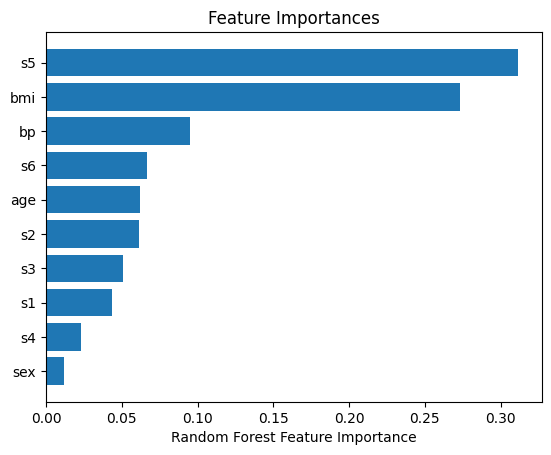

In [14]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [15]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
# initialize the model
model = RandomForestRegressor()
# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)
# see which features were selected
support = sfm.get_support()
# get feature names
print([
 x for x, y in zip(col_names, support) if y == True
])

['bmi', 's5']
